In [36]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import linear_model as lm

In [37]:
zipDataBase = pd.read_csv("zip_code_database.csv")["zip"].to_list()

In [38]:
partFrame = pd.read_csv("StudentSet.csv")
partFrame["Ethnicity"].replace("Black or African-American", "Black or African American", inplace=True)
partFrame["Ethnicity"].replace("Native American or Native Alaskan", "Native American", inplace=True)
for dropItem in ["1", "2", "3", "4", "5", "13", "Graduate", "Home School"]:
    partFrame.drop(partFrame[partFrame["Grade Level"] == dropItem].index, inplace=True)
partFrame["Grade Level"] = partFrame["Grade Level"].astype("int64")
partFrame.rename(columns={"Mailing Zip/Postal Code": "Zip Code"}, inplace=True)
partFrame = partFrame[partFrame["Zip Code"].apply(lambda x: len(str(x)) == 5)]
partFrame = partFrame[partFrame["Zip Code"].apply(lambda x: isinstance(x, int))]
partFrame = partFrame[partFrame["Zip Code"].apply(lambda x: x in zipDataBase)]
partFrame["Zip Code"] = partFrame["Zip Code"].astype("int64")
partFrame.drop("Chapter Affiliation: Account Name", inplace=True, axis=1)
partFrame.drop_duplicates(subset=["Contact ID"], inplace=True)
partFrame.to_csv("Test.csv", index=False)

C:\Users\mhwkm\AppData\Local\Temp\ipykernel_27752\3547729577.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  partFrame = pd.read_csv("StudentSet.csv")


In [39]:
from uszipcode import SearchEngine as zipSearch
partFrame = partFrame.assign(
    MediHouseIncome = [zipSearch().by_zipcode(partFrame["Zip Code"][row]).median_household_income for row in partFrame.index],
    PopDensity = [zipSearch().by_zipcode(partFrame["Zip Code"][row]).population_density for row in partFrame.index])
print(partFrame)

       Contact ID  Age  Gender                  Ethnicity  Grade Level  \
65536   FK-045347   12    Male         White or Caucasian            6   
65537   FK-045192   12    Male               Multi-Racial            7   
65539   FK-296034   12    Male         White or Caucasian            7   
65540   FK-229868   12    Male  Black or African American            6   
65541   FK-045345   12    Male         White or Caucasian            6   
...           ...  ...     ...                        ...          ...   
161190  FK-321054   12    Male         White or Caucasian            6   
161191  FK-056628   12  Female               Multi-Racial            9   
161192  FK-078501   13  Female               Multi-Racial            7   
161195  FK-078380   12  Female  Black or African American            7   
161196  FK-321030   12  Female         Latino or Hispanic            6   

        Zip Code  Participation Year  MediHouseIncome  PopDensity  
65536      77573                2019       

In [40]:
childSessionFrame = pd.read_csv("RegistrationData.csv")
completionSeries = pd.DataFrame(childSessionFrame["Contact ID"].value_counts()).reset_index(names="ConID")
completionSeries.rename(columns={"Contact ID": "ConID"}, inplace=True)
partFrame = partFrame.join(completionSeries.set_index("ConID"), on=["Contact ID"]).dropna()

In [41]:
partFrame.sort_values(by="Age", inplace=True)
reg = lm.LinearRegression()
reg.fit(partFrame[["Age", "Grade Level", "PopDensity", "MediHouseIncome"]], partFrame["count"])

LinearRegression()

                      Age  Grade Level  PopDensity  MediHouseIncome     count
Age              1.000000     0.865466    0.023106        -0.077012 -0.164460
Grade Level      0.865466     1.000000    0.044001        -0.057988 -0.104678
PopDensity       0.023106     0.044001    1.000000        -0.037126  0.090946
MediHouseIncome -0.077012    -0.057988   -0.037126         1.000000  0.069590
count           -0.164460    -0.104678    0.090946         0.069590  1.000000


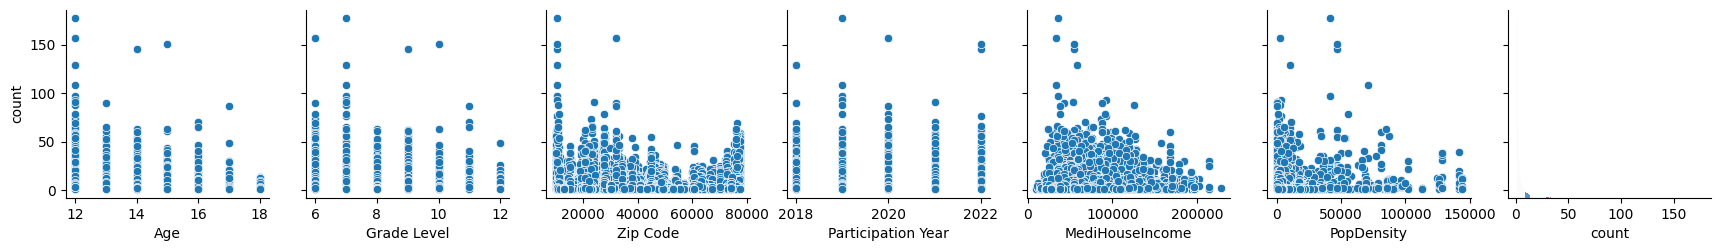

In [42]:
sb.pairplot(partFrame, y_vars="count")
print(partFrame[["Age", "Grade Level", "PopDensity", "MediHouseIncome", "count"]].corr())

In [ ]:
partFrame.to_csv("PartRelations.csv", index=False)